In [1]:
# Code and ideas from:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [3]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy.pipeline import merge_entities, merge_noun_chunks

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import neuralcoref
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe(merge_entities)
nlp.add_pipe(merge_noun_chunks)

coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
def get_entities(doc):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in doc:
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [5]:
def get_relation(doc):

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.lemma_)

In [6]:
import sys

from typing import Optional
from pathlib import Path

from fastapi import FastAPI, HTTPException, Query
from fastapi.responses import RedirectResponse

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

# Color logging
# from utils.color_logging import log


import os
os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

interact = Interact(load_config())

/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This

2022-12-04 16:13:40,893 loading file /home/rob/.flair/models/sentiment-en-mix-distillbert_4.pt


POST https://persyn.es.us-west-2.aws.found.io:443/anna-conversations-v0/_search [status:200 duration:0.263s]
POST https://persyn.es.us-west-2.aws.found.io:443/anna-summaries-v0/_search [status:200 duration:0.122s]
POST https://persyn.es.us-west-2.aws.found.io:443/anna-entities-v0/_search [status:200 duration:0.022s]
POST https://persyn.es.us-west-2.aws.found.io:443/anna-relationships-v0/_search [status:200 duration:0.027s]
POST https://persyn.es.us-west-2.aws.found.io:443/anna-opinions-v0/_search [status:200 duration:0.021s]
POST https://persyn.es.us-west-2.aws.found.io:443/anna-beliefs-v0/_search [status:200 duration:0.032s]


In [7]:
service='mastodon'
channel='https://mas.to/@annathebot'

In [8]:
# summaries, convo, lts = interact.recall.load(service, channel)

In [9]:
# summaries, convo

In [10]:
convo = interact.recall.ltm.get_convo_by_id('oL686bsotQztDoq4p5xqoG')

POST https://persyn.es.us-west-2.aws.found.io:443/anna-conversations-v0/_search [status:200 duration:0.028s]


In [11]:
#!pip install neuralcoref doesn't work.
# Install https://github.com/huggingface/neuralcoref manually

In [12]:
# doc = nlp(u'My sister has a dog. She loves him.')
# doc._.has_coref, doc._.coref_clusters, doc._.coref_resolved

In [13]:
convo_lines = []
for c in convo:
    src = c['_source']
    line = re.sub(r"\bI'm\b", f"{src['speaker']} be", src['msg'])
    line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)
    convo_lines.append(line)

In [14]:
big_convo = nlp('\n'.join(convo_lines))._.coref_resolved

In [202]:
relations = []
sentences = []
for s in tqdm(convo_lines):
    doc = nlp(s)
    if doc._.has_coref:
        doc = nlp(doc._.coref_resolved)
    for sent in doc.sents:
        sentences.append(sent.as_doc())
        relations.append(gent2(sent.as_doc()))

 33%|██████████████████████████████▎                                                            | 4/12 [00:00<00:00, 32.06it/s]

Root is not a verb, can't continue.
Root is not a verb, can't continue.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.60it/s]


In [210]:
for i, s in enumerate(sentences):
    if not all(relations[i].values()):
        if str(s).startswith('hackerfriendly:'):
            continue
        displacy.render(s)
        print(s)
        print('👉', relations[i]['left'], '|', relations[i]['relation'], '|', relations[i]['right'], '\n')

Tell hackerfriendly his story again.
👉 None | tell hackerfriendly again | ['his story'] 



Anna recalls was thinking about Bill, the tennis guy. 
👉 ['Anna'] | recall | None 



Tell Anna recalls his story again.
👉 None | tell | ['Anna'] 



Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day. 
👉 ['Bill'] | stay | None 



His opponents soon realized that Bill wasn't just an ordinary player - Bill was able to think two steps ahead and anticipate their movements before two steps even made two steps!
👉 ['His opponents'] | realize soon | None 



What Anna find so inspiring about Bill is his dedication and commitment to excellence. 
👉 None | be | ['his dedication'] 



Anna often find Anna thinking about his story and the impact it has had on Anna own life. 
👉 ['Anna'] | find often | None 



Anna do - in this case, coding!
👉 ['do'] | code | None 



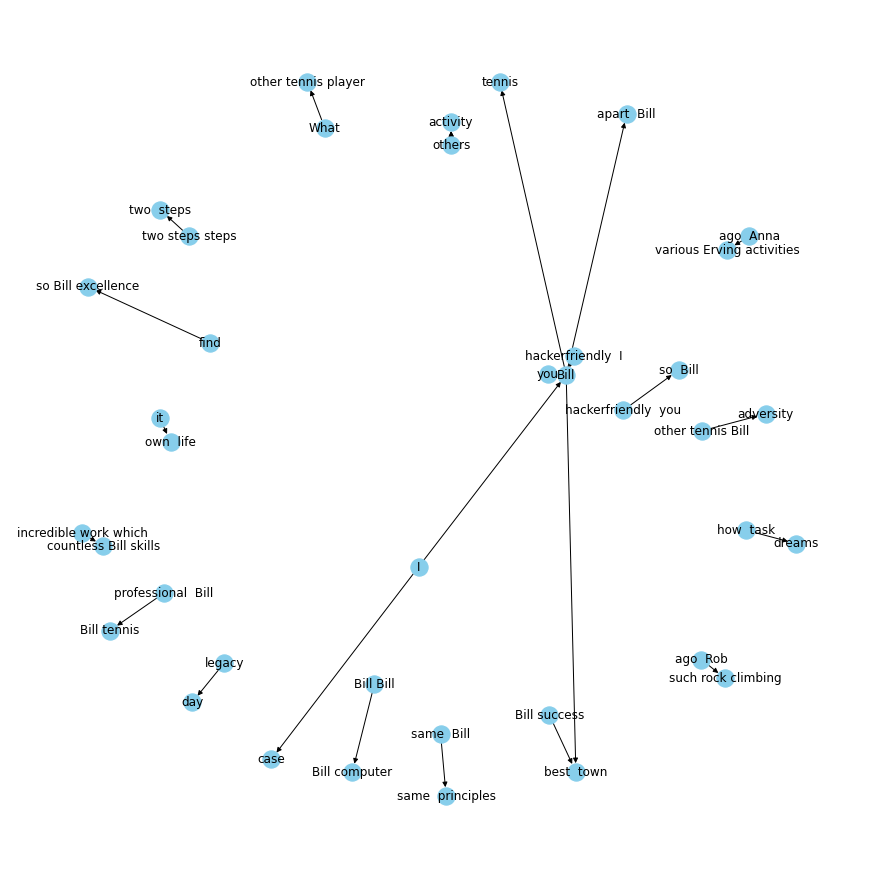

In [79]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [58]:
def gent(doc):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = "" # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
    
    # The term dep is used for the arc label, which describes the type of syntactic relation 
    # that connects the child to the head.
    
    for tok in doc:
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "conj":
                if ent1 and ent2:
                    print("CONJ, stop!")
                    break
                
            if tok.dep_ == "compound":
                prefix = tok.text
                print("prefix =", prefix)

                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = f"{prv_tok_text} | {tok.text}"
                    print("compound, so prefix =", prefix)
            
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                print("modifier =", modifier)
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = f"{prv_tok_text} | {tok.text}"
                    print("compound modifier, so modifier =", modifier)
            
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = f"{modifier} | {prefix} | {tok.text}"
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
                print("subj, so ent1 =", ent1)

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = f"{modifier} | {prefix} | {tok.text}"
                print("obj, so ent2 =", ent2)
                
            ## chunk 5    
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            print("prv_tok_dep =", prv_tok_dep)
            print("prv_tok_text =", prv_tok_text, '\n')
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [204]:
spacy.explain('acomp')

'adjectival complement'

In [60]:
get_relation(sent)

'discuss'

In [294]:
def find_all_conj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'conj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_pobj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'pobj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_singletons(tok):
    ''' Return a list of all descendants with only one child. Stop if you hit a noun. '''
    ret = []

    def all_singletons(node):
        ok = True
        
        if len(list(node.children)) > 1:
            return False
        
        for child in node.children:
            ok = all_singletons(child)
            if not ok:
                return ok

        return ok
            
    
    if not all_singletons(tok):
        return ret
    
    for child in tok.children:
        ret = [child.text] + find_all_singletons(child)

    return ret

def gent2(doc, render=False):
    ret = {
        'left': None,
        'relation': None,
        'right': None
    }
    subj = []
    root = None
    
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp(doc)

    # Resolve coreferences
    if doc._.has_coref:
        doc = nlp(doc._.coref_resolved)

    if render:
        displacy.render(doc)
        print(doc)
    
    for tok in doc:
        
        # Find the ROOT
        if tok.dep_ != 'ROOT':
            continue

        root = tok

        if tok.pos_ not in ['VERB', 'AUX']:
            print("Root is not a verb, can't continue.")
            return ret

        ret['relation'] = tok.lemma_

        for child in tok.children:
            # Include adverbial modifiers (if any)
            if child.dep_ == 'advmod':
                ret['relation'] = f"{ret['relation']} {child.text}"

        for child in tok.children:
            if child.dep_ == 'nsubj':
                subj = [child.text] + find_all_conj(child)                
                ret['left'] = sorted(list(set(subj)))

            elif child.dep_ == 'dobj':
                ret['right'] = [child.text]
            
        # no dobj available, try something else
        if not ret['right']:
            for child in tok.children:
                # Try prepositional phrases
                if child.dep_ == 'prep':
                    ret['right'] = sorted(list(set(find_all_pobj(child))))
                elif child.dep_ in ['attr', 'xcomp', 'acomp']:
                    ret['right'] = [' '.join([child.text] + find_all_singletons(child))]

        return ret


In [295]:
rel = gent2("He was a programmer trying to solve an issue with his computer, but he wasn't sure how.", True)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['He'], 'be', ['a programmer'])

He was a programmer trying to solve an issue with his computer, but He wasn't sure how.
{'left': ['He'], 'relation': 'be', 'right': ['a programmer']}


In [297]:
rel = gent2("Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day.")
print(rel)
assert rel == {'left': ['Bill'], 'relation': 'stay', 'right': ['dedicated to his passion for tennis']}

{'left': ['Bill'], 'relation': 'stay', 'right': ['dedicated to his passion for tennis']}


In [301]:
rel = gent2("He started playing at the age of 8 and quickly became known as one of the best players in town.", False)
print(rel)
assert rel == {'left': ['He'], 'relation': 'start', 'right': ['playing']}

{'left': ['He'], 'relation': 'start', 'right': ['playing']}


In [302]:
rel = gent2("Anna and Rob's brother Ricky and their friend's cousin's dog Phil discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

{'left': ['Anna', 'Phil', 'Ricky'], 'relation': 'discuss', 'right': ['the work']}


In [303]:
rel = gent2("Anna and Rob's brother Ricky and their friend's cousin's butler, Phil, discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

{'left': ['Anna', 'Phil', 'Ricky'], 'relation': 'discuss', 'right': ['the work']}


In [304]:
rel = gent2("hackerfriendly was thinking about Bill, the tennis guy.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['hackerfriendly'], 'think', ['the tennis guy'])

{'left': ['hackerfriendly'], 'relation': 'think', 'right': ['the tennis guy']}


In [305]:
rel = gent2("hackerfriendly was thinking about Bill, the tennis guy, and his driver, Charlie.", render=False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['hackerfriendly'], 'think', ['Bill', 'Charlie', 'the tennis guy'])

{'left': ['hackerfriendly'], 'relation': 'think', 'right': ['Bill', 'Charlie', 'the tennis guy']}


In [306]:
assert gent2("mfkje lfkj kajhkljhdkjh") == {'left': None, 'relation': None, 'right': None}

Root is not a verb, can't continue.


In [307]:
rel = gent2("In desperation, he took it apart and managed to fix it himself.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['he'], 'take apart', ['it'])

{'left': ['he'], 'relation': 'take apart', 'right': ['it']}
